In [1]:
import tweepy
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geocoder
from bs4 import BeautifulSoup
import requests
from urllib.request import urlopen, Request
import nltk as nl
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory as sf
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

ckey = 'rsBjYFtWjshnausnul2eZVZYG'
csec = 'y0B8FuYfIvsGMiHgKadMD0pun0kIv6Y4nOuT1cplU9f2anuYmz'
atoken = '1159389149368950784-o0UgdZVbzOmhmT7DOCev5Ib8b0NLwA'
atokens = 'L7n5ThIlljniU8qTpKAeA3ydSkTIPbZLsZhO9WzvnqXcU'

auth = tweepy.OAuthHandler(ckey, csec); auth.set_access_token(atoken,atokens)
api = tweepy.API(auth)

In [2]:
def clean_text(text):
    punctuations = '''!()-[]};:'{",<>./?@#$%^&*_~'''
    text = re.sub('https://','',text); no_punct = ""
    for char in text:
        if char not in punctuations: no_punct = no_punct + char
    text = no_punct; text = text.lower()
    text = re.sub('[0-9][^\w\s]*','',text)
    text = re.sub('\n','',text); text = text.strip()
    stop_words = set(stopwords.words('indonesian'))
    word_token = word_tokenize(text)
    new_text = ' '.join([w for w in word_token if not w in stop_words])
    return new_text

def tweet_sentiment(cleantweet):
    kata_pos = open("kata_positif.txt","r").readlines()
    kata_neg = open("kata_negatif.txt","r").readlines()
    hasil = []
    c_pos = 0; c_neg = 0
    for kata in kata_pos:
        if kata.strip() in cleantweet:
            c_pos+=1
    for kata in kata_neg:
        if kata.strip() in cleantweet:
            c_neg+=1
    hasil=(c_pos-c_neg)
    if hasil>0: return 1
    else : return 0

def crawl_tweets(keywords, count, sdate, udate):
    g = geocoder.ip('me').latlng
    location = api.trends_closest(g[0],g[1])[0]['woeid']
    search = keywords
    new_search = search; cleaned = ""; idx = 0
    list_tweet = []
    tweets = tweepy.Cursor(api.search, q=new_search, since=sdate, until=udate, lang="id").items(count)
    for tweet in tweets:
        cleaned = clean_text(tweet.text)
        sentiment = tweet_sentiment(cleaned)
        if (tweet.retweeted): retweet = 1
        else: retweet = 0
        list_tweet.append([tweet.user.id,tweet.user.screen_name,retweet,tweet.created_at, cleaned, sentiment])
        idx+=1
    df = pd.DataFrame(list_tweet, columns=['userid','screenname','retweeted','createdat','cleanedtext','sentiment'])
    return df
df_1 = crawl_tweets('covid',500,"2021-03-01","2021-03-29") 
df_1.to_csv('covidcrawl.csv')
df_1

,userid,screenname,retweeted,createdat,cleanedtext,sentiment
0,1595045810,AnotherAznTart,0,2021-03-28 23:59:43,rt kkmputrajaya wanita hamil kumpulan berisiko...,0
1,409925007,RDYSPTR,0,2021-03-28 23:59:40,rt puthutea cek satpam teman yg tersebar wag w...,1
2,1274974402048741377,Cr07fans1,0,2021-03-28 23:59:40,rt abuwaras patut apresiasi larangan mudik yg ...,0
3,1357700239168217090,RahmanR33500117,0,2021-03-28 23:59:38,rt djplkemenhub kawanlaut kemenhub penerapan a...,0
4,906066821723201536,ftnhhshm,0,2021-03-28 23:59:32,rt kkmputrajaya wanita hamil kumpulan berisiko...,0
...,...,...,...,...,...,...
495,4437918318,akmalhjsaftu,0,2021-03-28 23:15:44,rt theghrack salam sy dgn rendah hati doakan k...,0
496,596216213,jamal_bawean,0,2021-03-28 23:15:39,rt drkoko belasan siswa positif covid ikuti pe...,1
497,1210882111973933058,santuyparuy09,0,2021-03-28 23:15:38,rt segipascal berhubung utbk suka badut suka n...,1
498,834572846072418305,kotapontianak_,0,2021-03-28 23:15:36,informasi data covid kota pontianak data diper...,1


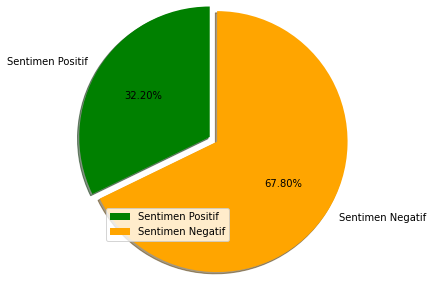

<Figure size 5400x3600 with 0 Axes>

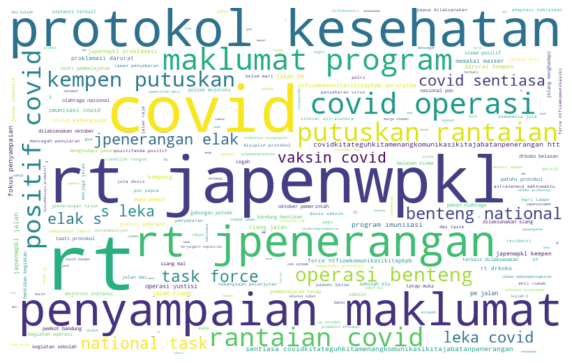

<Figure size 5400x3600 with 0 Axes>

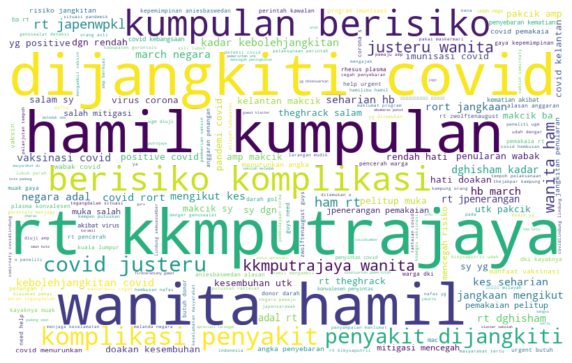

In [3]:
df = df_1
sentimen = ['Sentimen Positif','Sentimen Negatif']
irisan = [(df['sentiment']!=0).sum(), (df['sentiment']==0).sum()]
warna = ['green','orange']
plt.pie(irisan,labels=sentimen,colors=warna,startangle=90,shadow=True,explode=(0,0.1),radius=1.5,autopct='%1.2f%%')
plt.legend()
    
# menghitung banyak kata yang sering digunakan pada sentimen positif
optimis=' '.join([teks for teks in df['cleanedtext'][df['sentiment']==1]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(optimis)
plt.figure(dpi=900)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear");plt.axis('off')

# menghitung banyak kata yang sering digunakan pada sentimen negatif
pesimis=' '.join([teks for teks in df['cleanedtext'][df['sentiment']==0]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(pesimis)
plt.figure(dpi=900)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear");plt.axis('off')
plt.show()

In [4]:
import networkx as nx
kata_kunci = 'covid'
sdate, udate = "2021-03-01","2021-03-29"
count = 500
# tweets = api.search(q=kata_kunci, lang='id', count=500, tweet_mode='extended')
tweets = tweepy.Cursor(api.search, q=kata_kunci, since=sdate, until=udate, lang="id", tweet_mode='extended').items(count)
user = []
rt_user = []
for tweet in tweets:
    try:
        rt_user.append(tweet._json['retweeted_status']['user']['screen_name'])
        user.append(tweet.user.screen_name)
    except:
        pass

In [5]:
resulting_list = list(user)
resulting_list.extend(x for x in rt_user if x not in resulting_list)
print(len(resulting_list))

G = nx.Graph()

G.add_nodes_from(resulting_list)
for i in range(len(user)):
    G.add_edge(user[i],rt_user[i])

# print(G.nodes(data=True))
# print(G.edges())

389


In [6]:
cl = pd.DataFrame(nx.closeness_centrality(G), index=['Closeness Centrality']).T
cl.sort_values(by=['Closeness Centrality'], inplace=True, ascending=False)
cl.head(10)

,Closeness Centrality
KKMPutrajaya,0.207143
Jchris_68,0.161423
tbgsem,0.155808
Ahmad_KanekiKen,0.155808
lyra_fara,0.149316
ParamesPolaris,0.149316
KelingMenua8,0.149316
AnotherAznTart,0.132725
haziqProperty,0.132725
vouzmeyouz7,0.132725


<AxesSubplot:>

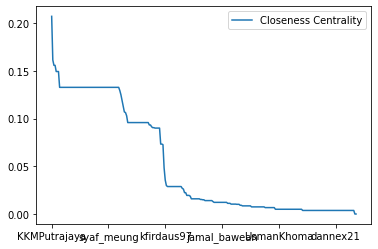

In [9]:
cl.plot()

In [7]:
bt = pd.DataFrame(nx.betweenness_centrality(G, normalized=False),index=['Betweeness Centrality']).T
bt.sort_values(by=['Betweeness Centrality'], inplace=True, ascending=False)
bt.head(10)

,Betweeness Centrality
KKMPutrajaya,4161.250000
DGHisham,1676.750000
JPenerangan,864.142857
Jchris_68,758.547619
Ahmad_KanekiKen,471.333333
tbgsem,471.333333
KelingMenua8,438.178571
ParamesPolaris,389.178571
lyra_fara,389.178571
JapenSarawak,251.464286


<AxesSubplot:>

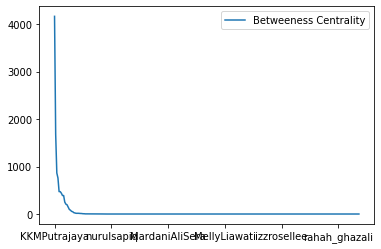

In [11]:
bt.plot ()

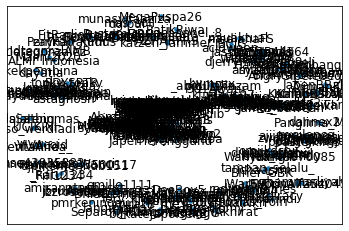

In [14]:
nx.draw_networkx(G, node_size=12)
nx.write_gexf(G, "covid_gexf.gexf")
plt.show()

In [ ]:
"terspektakuler",
"terstruktur",

In [1]:
kata_pos = open("kata_positif.txt","r").readlines()
kata_neg = open("kata_negatif.txt","r").readlines()
y=[]; q = []

x = list(kata_pos)
for i in range(len(x)):
    x[i] = x[i].rstrip("\n")
    y.append('"'+x[i]+'",')

y
with open('listpos.txt', 'w') as filehandle:
    filehandle.writelines("%s" % place for place in y)

p = list(kata_neg)
for i in range(len(x)):
    p[i] = p[i].rstrip("\n")
    q.append('"'+p[i]+'",')

q
with open('listneg.txt', 'w') as filehandle:
    filehandle.writelines("%s" % place for place in q)